## Formalizing psychological theories as computational models

In this notebook we will look at how to formalize several simple models of decision making as computational models, and fit them to an existing dataset.

First we need to set up our Python environment.

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from psych125.prospect_theory import (
    calc_subjective_utility, calc_utility_diff, calc_prob_accept,
    fit_pt_model
)
from keras.models import Sequential
from keras.layers import Dense
from keras_visualizer import visualizer
from tensorflow.keras import regularizers
from firthlogist import FirthLogisticRegression


plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.autolayout'] = True

2023-11-07 07:53:21.686722: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 07:53:21.688721: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 07:53:21.717846: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 07:53:21.717880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 07:53:21.717911: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### Load data

For this notebook we will use the behavioral data collected in a study called the Neuroimaging Analysis Replication and Prediction Study (NARPS), in which participants completed a "mixed gambles task" in which they were shown gambles in which they had a 50% chance of winning some amount and a 50% chance of losing some other amount.  There were two different conditions across subjects, which differed in the specific amounts of gain and loss that were presented; we will focus on the "equal indifference" condition because it generally had more decisions to accept, making the data easier to analyze.

In [2]:

# load data and clean up

alldata = pd.read_csv('https://raw.githubusercontent.com/poldrack/ResearchMethods/main/Data/NARPS/narps_behav_data.csv')
alldata = alldata.query('condition == "equalIndifference"')
alldata['cert'] = 0  # the certain outcome (if they reject the gamble) which is always zero here
alldata = alldata.rename({'RT': 'rt', 'accept': 'response'}, axis=1)
subjects = alldata['sub'].unique()

print(f'number of subjects = {len(subjects)}')


number of subjects = 54


### Visualize the data

First we will visualize various aspects of the data, collapsing across all subjects. First we plot the proportion of trials where the subject accepted the gamble, as a function of the size of the potential gain in the gamble.

Text(0, 0.5, 'proportion accepted')

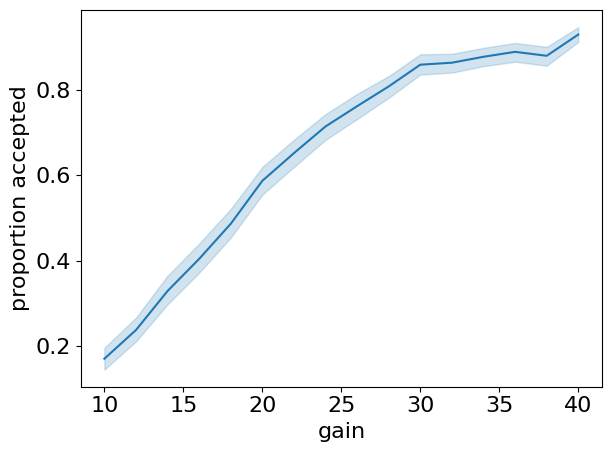

In [3]:
sns.lineplot(data=alldata, x='gain', y='response', legend=False)
plt.ylabel('proportion accepted')

We can see that, as expected, the likelihood of accepting the gamble goes up as the amount that could be gained goes up, averaging over all levels of loss.

Now let's look at responses as a function of the size of the potential loss:

Text(0, 0.5, 'proportion accepted')

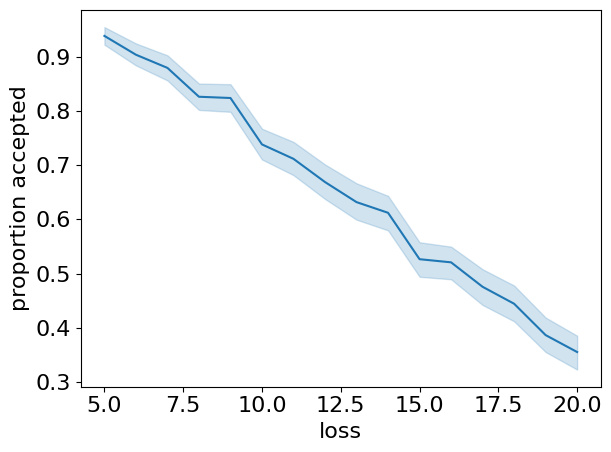

In [4]:
sns.lineplot(data=alldata, x='loss', y='response', legend=False)
plt.ylabel('proportion accepted')

Again, as expected we see that subjects are less likely to accept gambles as the potential loss gets bigger.

We'd really like to see both variables at the same time, which we can do using a "heatmap":

<Axes: xlabel='loss', ylabel='gain'>

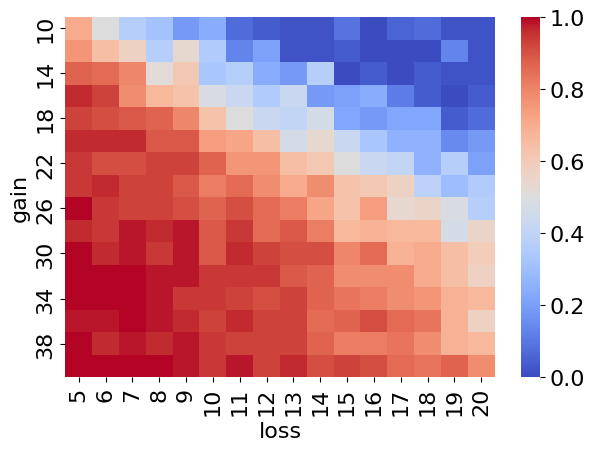

In [5]:
hmap_data = alldata.groupby(['gain', 'loss'])['response'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm')

The color here reflects the likelihood of accepting the gamble for each combination of gain and loss.  We see that the highest probabilities are in the lower left, where the gain is highest and the loss is lowest.  Conversely, the lowest rates of acceptance are in the top right, where the loss is highest and the gain is lowest.


### Fitting a statistical model

The first place to start in understanding the data is to fit a statistical model that assesses the relationships between different variables in the data. Because the outcome (Y) variable is binary (i.e. the subject responds or not on each trial), we can't use standard linear regression; the main reason is that linear regression isn't bounded by zero and one, whereas our responses are coded as zero (reject) and one (accept).  In addition, a binary outcome data will violate the assumption of normally distributed residuals that is required by linear regression.

An appropriate model to use when one wants to build a linear model with binary outcomes is called *logistic regression*. The interpretation of the parameter estimates is slightly different from linear regression; whereas in linear regression we assume that the parameter describes the response to a one-unit change in X, in logistic regression the parameter describes a one-unit change in the log-odds of X (which can be translated back into a probabilility value by exponentiating them).

Here we will loop through all of our subjects and fit a logistic regression model separately for each person.  There are ways to fit models with all subjects at once, but for our purposes here we are interested in the individual model fits.

In [6]:
# create some variables to save the outputs
lr_params = []
fl = {}
subdata = {}

for sub in subjects:
    subdata[sub] = alldata.query(f'sub == {sub}')
    # use regularlized logistic regression to estimate gain/loss parameters
    # since some subjects have perfect separation
    fl[sub] = FirthLogisticRegression(max_iter=1000, max_halfstep=1000,
                                  skip_pvals=True, skip_ci=True)
    fl[sub].fit(subdata[sub][['gain', 'loss']], subdata[sub]['response'])
    accuracy = np.mean(
        fl[sub].predict(subdata[sub][['gain', 'loss']]) == subdata[sub]['response'])
    lr_params.append([
        sub, accuracy,
        fl[sub].coef_[0], fl[sub].coef_[1], fl[sub].intercept_])

lr_params_df = pd.DataFrame(lr_params, columns=['sub', 'accuracy', 'gain', 'loss', 'intercept'])


/home/poldrack/miniconda3/envs/py311/lib/python3.11/site-packages/firthlogist/firthlogist.py:323: RuntimeWarning: divide by zero encountered in log
  return -1 * (np.sum(y * np.log(preds) + (1 - y) * np.log(1 - preds)) + penalty)
/home/poldrack/miniconda3/envs/py311/lib/python3.11/site-packages/firthlogist/firthlogist.py:323: RuntimeWarning: invalid value encountered in multiply
  return -1 * (np.sum(y * np.log(preds) + (1 - y) * np.log(1 - preds)) + penalty)
/home/poldrack/miniconda3/envs/py311/lib/python3.11/site-packages/firthlogist/firthlogist.py:323: RuntimeWarning: divide by zero encountered in log
  return -1 * (np.sum(y * np.log(preds) + (1 - y) * np.log(1 - preds)) + penalty)
/home/poldrack/miniconda3/envs/py311/lib/python3.11/site-packages/firthlogist/firthlogist.py:323: RuntimeWarning: invalid value encountered in multiply
  return -1 * (np.sum(y * np.log(preds) + (1 - y) * np.log(1 - preds)) + penalty)
/home/poldrack/miniconda3/envs/py311/lib/python3.11/site-packages/firthl

Let's look at how well the model performed. First, we can look at how accurately the model predicted each response for each subject:

In [7]:
print('median accuracy = ', np.median(lr_params_df.accuracy))

median accuracy =  0.908203125


The model predicted over 90% of the responses correctly, which seems pretty good.  Now let's look at the parameter estimates to see if we can get any insight into what's going on.

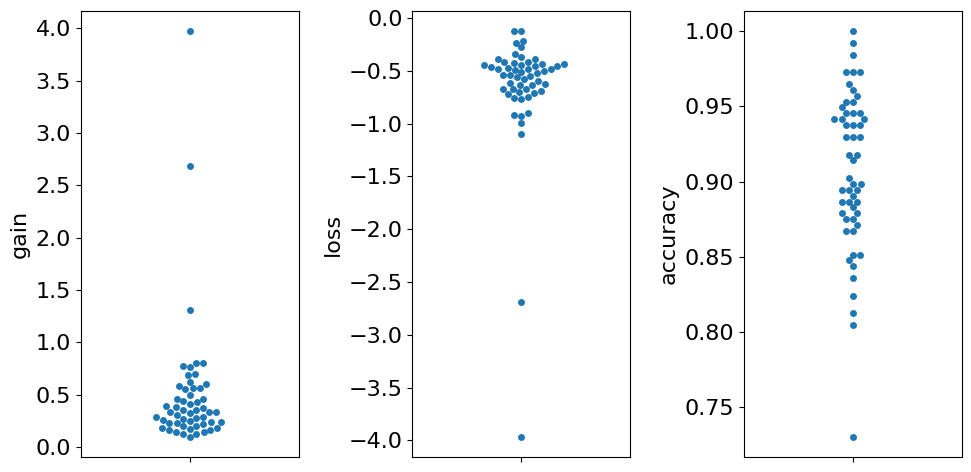

In [8]:

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.swarmplot(lr_params_df.gain)
plt.subplot(1,3,2)
sns.swarmplot(lr_params_df.loss)
plt.subplot(1,3,3)
sns.swarmplot(lr_params_df.accuracy)
plt.tight_layout()



The plot on the left shows that all subjects had a positive gain parameter; this is unsurprising but helpful in showing that the subjects were likely performing the task correctly. Similarly, all subjects had a negative loss parameter; it's negative because the loss values were entered into the model as positive numbers.  On the right we can see that the model varied in how well it predicted the responses of individual subjects; for most it did quite well, but for one it seemed much worse.

Now let's look at what the output of the model looks like for a single subject.

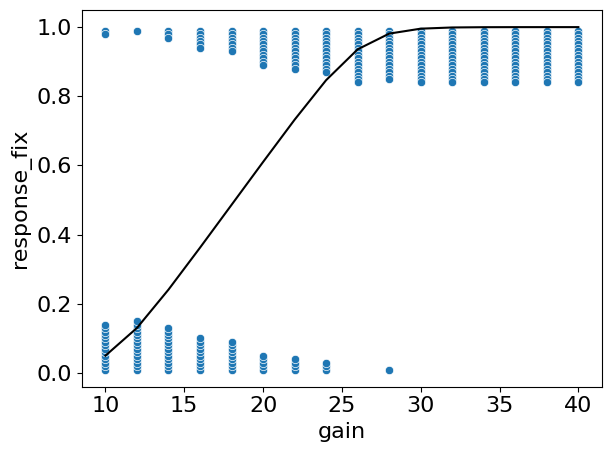

In [9]:
# plot logistic response for a given subject

sub = 9
plot_data = subdata[sub].copy()
plot_data['response_fix'] = None
offset = .01
coord_ctr = {}
for i in plot_data.index:
    coords = (plot_data.loc[i, 'gain'], plot_data.loc[i, 'response'])
    if coords in coord_ctr:
        coord_ctr[coords] += 1
    else:
        coord_ctr[coords] = 1
    if plot_data.loc[i, 'response'] == 1:
        plot_data.loc[i, 'response_fix'] = 1 - offset * coord_ctr[coords]
    else:
        plot_data.loc[i, 'response_fix'] =  offset * coord_ctr[coords]

plot_data['pred_lr'] = fl[sub].predict_proba(plot_data[['gain', 'loss']])[:,1]
sns.scatterplot(data=plot_data, x='gain', y='response_fix',
                legend=False)
sns.lineplot(data=plot_data,
             x='gain',
             y='pred_lr',
             legend=False, errorbar=None, color='black')
plt.tight_layout()



The blue dots refer to accept decisions (on top) or reject decisions (on bottom).  The black line shows the probability of accepting for each level of gain; note that it flattens out at one; if we had used linear regression instead, it would have kept going up!

We can also use a heatmap to show the model's estimates of the probability of accepting for each combination of gain and loss.  On the left we see the predicted response, and on the right we see the subject's actual responses:


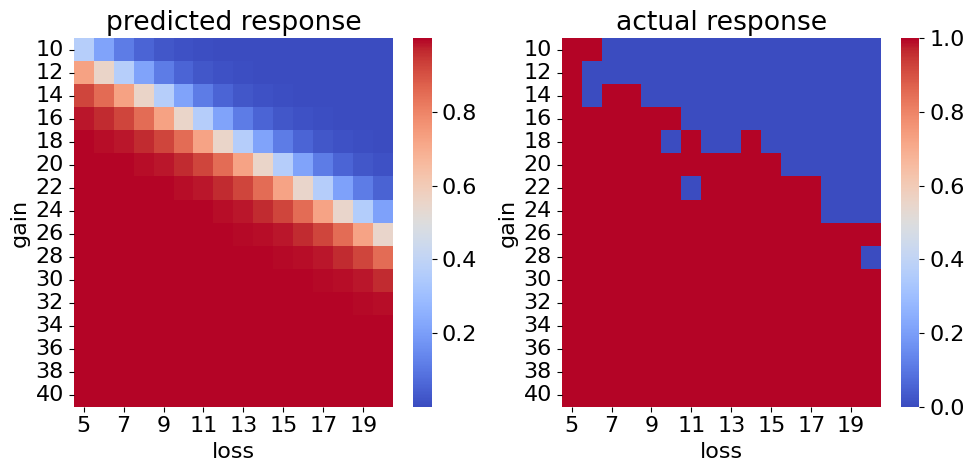

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(plot_data.groupby(['gain', 'loss'])['pred_lr'].mean().unstack(),
            cmap='coolwarm')
plt.title('predicted response')
plt.subplot(1,2,2)
sns.heatmap(plot_data.groupby(['gain', 'loss'])['response'].mean().unstack(),
            cmap='coolwarm')
plt.title('actual response')

plt.tight_layout()



The model does quite a good job of predicting the actual responses for this subject.

## Computational models for the task

The logistic regression model is a statistical model that relates aspects of the task to the behavior, and does quite a good job of predicting the behavior.  However, it doesn't necessarily give us insight into the underlying mechanisms of decision making.  Now we will implement several possible models of decision making, to see how theories can be turned into computational models.

### Random responding with bias

A simple model is that subjects simply respond randomly (that is, guess), but that they might have a bias towards accepting or rejecting.  In this model, we will determine their bias according to the proportion of gambles they accepted, and then respond randomly in such a way that accepts that same proportion of gambles.  

In [11]:

# fit random guessing with bias model

def test_guessing_model(df, n_iter=1000):
    bias = np.mean(df['response'])
    acc = []
    for i in range(n_iter):
        guesses = np.random.binomial(1, bias, size=df.shape[0])
        acc.append(np.mean(np.array(guesses) == df['response']))
    return np.mean(acc)

sub_guessing_pars = {}
for sub in subjects:
    bias = np.mean(subdata[sub]['response'])
    sub_guessing_pars[sub] = [bias, test_guessing_model(subdata[sub])]

sub_guessing_pars_df = pd.DataFrame(sub_guessing_pars).T
sub_guessing_pars_df.columns = ['bias', 'accuracy']
print(f'median accuracy (guessing model with bias) = {np.median(sub_guessing_pars_df.accuracy):.02}')

median accuracy (guessing model with bias) = 0.58


This model is much less accurate at predicting the subject's responses, which is probably not surprising because the analyses above showed us that the subjects were responding strongly to the size of the gain or loss, which would not be the case if they were responding randomly.  Let's look at the distribution of accuracy values across subjects, and also look at how accuracy relates to their degree of bias:

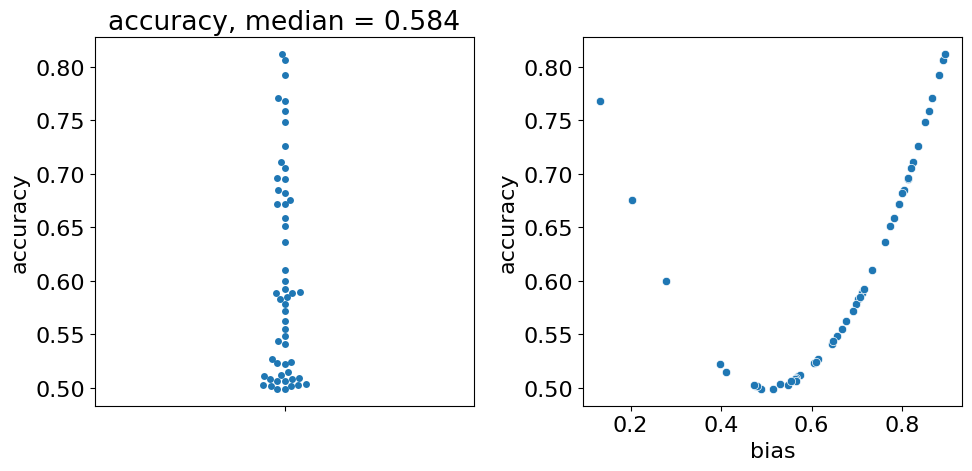

In [12]:
# plot accuracy vs bias
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.swarmplot(sub_guessing_pars_df['accuracy'])
plt.title(f'accuracy, median = {np.median(sub_guessing_pars_df.accuracy):.03}')

plt.subplot(1,2,2)
sns.scatterplot(data=sub_guessing_pars_df, x='bias', y='accuracy')
plt.tight_layout()
plt.savefig('guessing_model_accuracy.png')

We see that there is a range of accuracies (on the left).  The plot on the right shows that there is a very close relationship between the accuracy with which we can predict the subject's response, and their bias towards one or the other response. This makes sense; if a subject accepts all gambles, then we can perfectly predict their responses simply by accepting all gambles, regardless of the actual values.

## Expected utility model

Now let's look at a model that is motivated by economic theory.  There is a longstanding idea in economics that states that people make decisions based on the value of outcomes, but that their response to increasing value shows diminishing returns (i.e. it is concave). This is referred to *expected utility*.  Let's plot this:

u(10) - u(0) = 6.3
u(20) - u(10) = 4.7


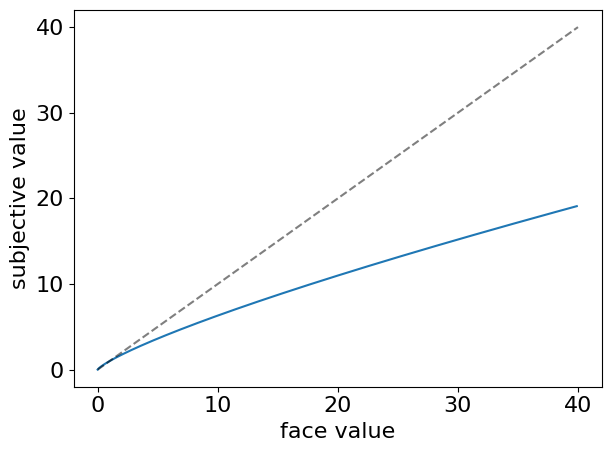

In [13]:

# plot utility function for EU model

values = np.arange(0, 40, .1)
rho = 0.8
y = values ** rho

plt.plot(values, y)
plt.plot([0,40],[0,40], color='black', linestyle='--', alpha=0.5)
plt.xlabel('face value')
plt.ylabel('subjective value')

print(f'u(10) - u(0) = {y[values==10][0] - y[0]:.02}')
print(f'u(20) - u(10) = {y[values==20][0] - y[values==10][0]:.02}')


In this case we have set the rho parameter to 0.8, which is a substantial amount of convexity.  In this case, the difference in utility between $10 and $0 is 6.3 units, whereas the difference between $20 and $10 is only 4.7 units.  

To generate responses from the EU model, we need to translate expected utility into a probability of accepting the gamble. We do that using a *sigmoid* function:

$$
p(accept) = \frac{1} {1 + e^{u_{gain} - u_{loss}}}
$$

where $u_{gain}$ and $u_{loss}$ are the expected utilities of the gain and loss values in the gamble respectively.  This function looks like this:

Text(0.5, 0, 'gain - loss')

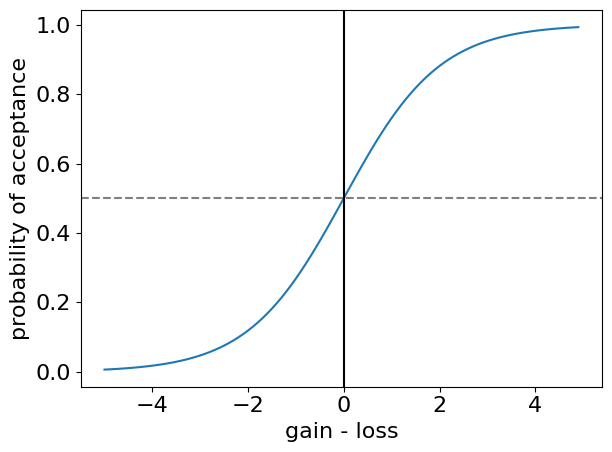

In [14]:

# plot sigmoid

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.arange(-5, 5, .1)
y = sigmoid(x)
plt.plot(x, y)
plt.axhline(0.5, color='black', linestyle='--', alpha=0.5)
plt.axvline(0, color='black')
plt.ylabel('probability of acceptance')
plt.xlabel('gain - loss')


Using this model, we can estimate the rho parameter that best fits the data for each individual in the dataset.  

0.859375
0.8125
0.5703125
0.7109375
0.890625
0.8828125
0.60546875
0.64453125
0.65625
0.703125
0.8671875
0.41015625
0.7109375
0.69921875
0.67578125
0.515625
0.27734375
0.79296875
0.89453125
0.6484375
0.8515625
0.48828125
0.5625
0.57421875
0.4765625
0.56640625
0.48046875
0.546875
0.8125
0.8046875
0.61328125
0.82421875
0.5625
0.7109375
0.53125
0.47265625
0.56640625
0.71484375
0.66796875
0.3984375
0.8359375
0.609375
0.80078125
0.69140625
0.70703125
0.79296875
0.1328125
0.5546875
0.78125
0.7734375
0.203125
0.8203125
0.734375
0.76171875


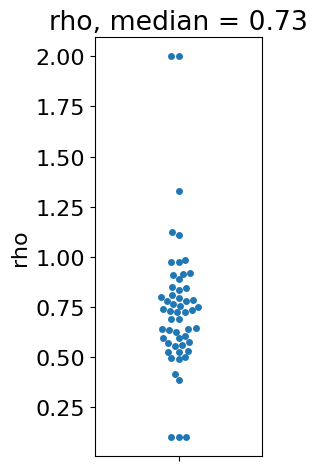

In [15]:
# estimate EU model parameters
# equivalent to prospect theory with lambda = 1

sub_pars_EU = {}
for sub in subjects:
    try:
      pars_est, ll = fit_pt_model(subdata[sub],
                              bounds=((1, 1), (0.1, 2), (1, 1)))
    except RuntimeError:
      print(f'could not fit subject {sub}')
      continue
    sub_pars_EU[sub] = np.hstack((pars_est, ll))

sub_pars_EU_df = pd.DataFrame(sub_pars_EU).T
sub_pars_EU_df.columns = ['lambda', 'rho', 'mu', 'll']

plt.figure(figsize=(3,5))
sns.swarmplot(sub_pars_EU_df.rho)
plt.title(f'rho, median = {np.median(sub_pars_EU_df["rho"]):.02}')
plt.tight_layout()


Here we see that there is a fairly broad range of estimated curvature values.  Most subjects are in the 0.5-1.0 range, but a few are at zero, and several have rho values greater than one, which means that they are actually risk-seeking (which doesn't really happen so it must be a flaw in how the parameters are being fitted).  We can also plot the predicted number of accepted gambles against the actual number of accepted gambles, and test the accuracy of the model at predicting the subjects' responses:

median accuracy =  0.80859375


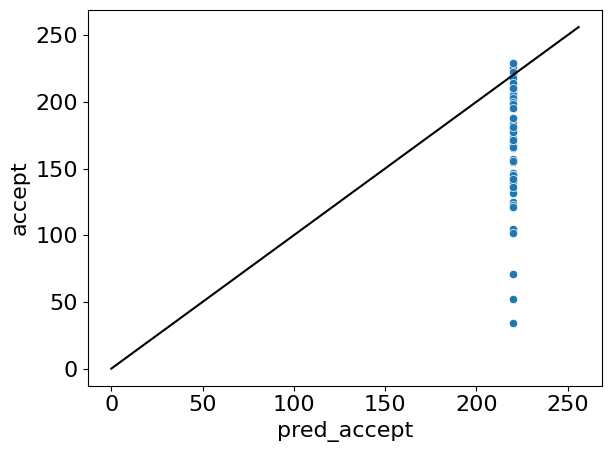

In [16]:

def get_predicted_output(sub_pars, subdata):
    pred_output = []
    for sub, pars in sub_pars.items():
        cert_su = [calc_subjective_utility(i, pars[0], pars[1]) for i in subdata[sub].cert]
        loss_su = [calc_subjective_utility(-1 * i, pars[0], pars[1]) for i in subdata[sub].loss]
        gain_su = [calc_subjective_utility(i, pars[0], pars[1]) for i in subdata[sub].gain]
        gamble_cert_diff = calc_utility_diff(gain_su, loss_su, cert_su)
        prob_accept = calc_prob_accept(gamble_cert_diff, mu = pars[2])
        n_pred_accepted = np.sum(prob_accept > 0.5)
        n_accepted = np.sum(subdata[sub].response)
        pred_acc = np.mean((prob_accept > 0.5) == subdata[sub].response)
        pred_output.append([n_pred_accepted, n_accepted, pred_acc, sub, pars[0], pars[1], pars[2]])

    return pd.DataFrame(pred_output, columns=['pred_accept', 'accept', 'predacc', 'sub', 'lambda', 'rho', 'mu'])

pred_output_EU_df = get_predicted_output(sub_pars_EU, subdata)
sns.scatterplot(data=pred_output_EU_df, x='pred_accept', y='accept',
                legend=False)
plt.plot([0,256],[0,256], color='black')
plt.savefig('narps_PT_pred_vs_actual.png')

print('median accuracy = ', np.median(pred_output_EU_df.predacc))

The first thing that we see is that the model is not very good at predicting the subjects' responses; its accuracy is well below the logistic regression model, though better than the random guessing model.  What you should notice from the plot is that the model predicts the same number of accepted responses for each subject (hence what looks like a vertical line), despite the fact that subjects varied substantially in the number of gambles they accepted.  This happens because the model predicts that the subject should accept any gamble where the potential gain is greater than the potential loss; which clearly doesn't accurately describe the subjects' behavior.

## Prospect theory

Now we turn to prospect theory (Kahneman & Tversky, 1979), which is one of the best supported models of decision making.  Kahneman won the Nobel Prize in Economics in 2002 for this work; Tversky would have also won but died in 1996 as a Stanford Professor.  

We will gloss over many of the details of prospect theory and focus on its value function, which states that value differs for gains and losses:



We can estimate the best fitting parameters for each subject:

0.859375
0.8125
0.5703125
0.7109375
0.890625
0.8828125
0.60546875
0.64453125
0.65625
0.703125
0.8671875
0.41015625
0.7109375
0.69921875
0.67578125
0.515625
0.27734375
0.79296875
0.89453125
0.6484375
0.8515625
0.48828125
0.5625
0.57421875
0.4765625
0.56640625
0.48046875
0.546875
0.8125
0.8046875
0.61328125
0.82421875
0.5625
0.7109375
0.53125
0.47265625
0.56640625
0.71484375
0.66796875
0.3984375
0.8359375
0.609375
0.80078125
0.69140625
0.70703125
0.79296875
0.1328125
0.5546875
0.78125
0.7734375
0.203125
0.8203125
0.734375


/home/poldrack/miniconda3/envs/py311/lib/python3.11/site-packages/psych125/prospect_theory.py:34: RuntimeWarning: overflow encountered in exp
  return (1 + np.exp(-mu * (gamble_cert_diff))) ** -1


0.76171875


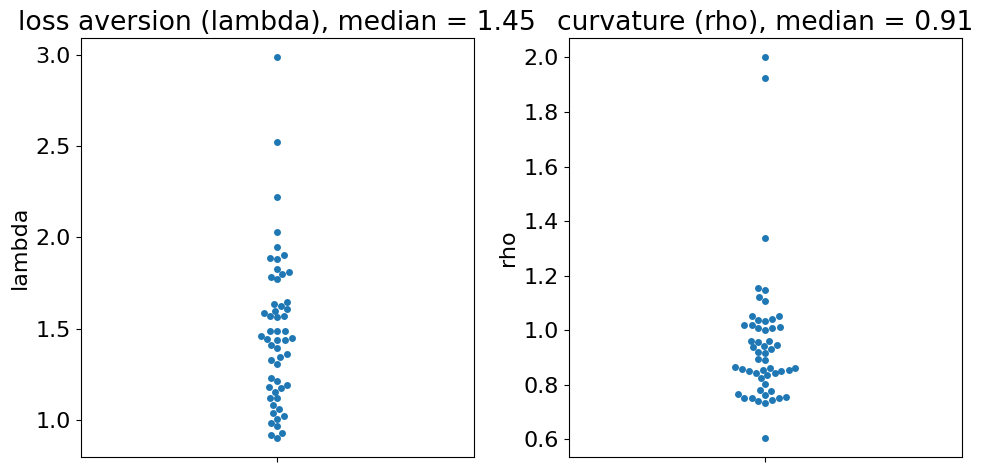

In [17]:
# estimate prospect theory parameters

sub_pars_PT = {}
for sub in subjects:
    try:
      pars_est, ll = fit_pt_model(subdata[sub],
                              bounds=((0, None), (0.1, 2), (1, 1)))
    except RuntimeError:
      print(f'could not fit subject {sub}')
      continue
    sub_pars_PT[sub] = np.hstack((pars_est, ll))

sub_pars_PT_df = pd.DataFrame(sub_pars_PT).T
sub_pars_PT_df.columns = ['lambda', 'rho', 'mu', ll]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.swarmplot(sub_pars_PT_df['lambda'])
plt.title(f'loss aversion (lambda), median = {np.median(sub_pars_PT_df["lambda"]):.03}')
plt.subplot(1,2,2)
sns.swarmplot(sub_pars_PT_df.rho)
plt.title(f'curvature (rho), median = {np.median(sub_pars_PT_df["rho"]):.02}')

plt.tight_layout()



Here we see that nearly all subjects show a loss aversion parameter greater than 1, reflecting the fact that for most subjects the impact of a loss is greater than the impact of the same sized gain.  Most subjects show a curvature of less than one, though a few are above one.  

We can plot the prospect theory value function based on the median paramters.

Text(0.5, 0, 'face value')

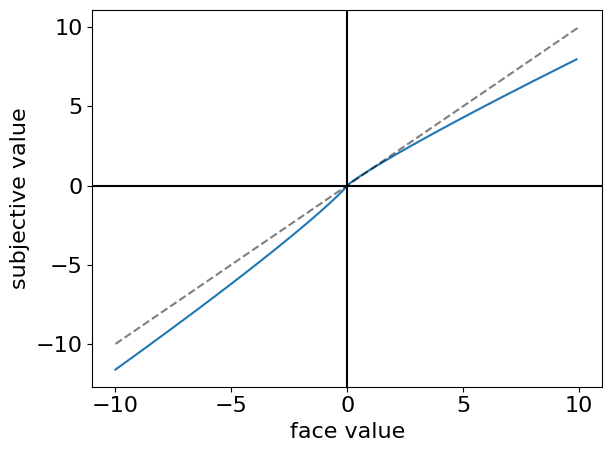

In [26]:
# plot prospect theory value function for median parameters

values = np.arange(-10, 10, .1)
su = [calc_subjective_utility(i, np.median(sub_pars_PT_df['lambda']),
                                np.median(sub_pars_PT_df['rho'])) for i in values]
plt.plot(values, su)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.plot([-10, 10], [-10,10], linestyle='--', color='black', alpha=0.5)
plt.ylabel('subjective value')
plt.xlabel('face value')


We can also plot the number of accepted gambles against the predicted number of gambles for each subject:

median accuracy =  0.90234375


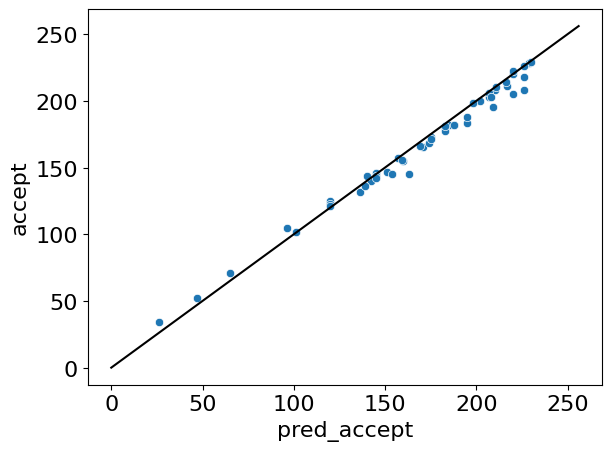

In [19]:
# plot predicted # of accepted gambles vs actual for each subject

pred_output_PT_df = get_predicted_output(sub_pars_PT, subdata)
sns.scatterplot(data=pred_output_PT_df, x='pred_accept', y='accept', legend=False)
plt.plot([0,256],[0,256], color='black')

print('median accuracy = ', np.median(pred_output_PT_df.predacc))

Here we see that the predictions map closely to the actual number of accepted gambles, and that the accuracy of the model is quite high.

## Neural network model

Here we will fit an artificial neural network to each subject's behavior.  The network has two input nodes (which reflect the gain and loss values respectively), three hidden units, and one output unit.  Fitting these models will take a few minutes, depending on your computing power.

In [20]:
# fit a neural network
def fit_nn_model(df, verbose=0):

    # define model
    model = Sequential()
    model.add(Dense(3, activation='relu', input_dim=2,
                    activity_regularizer=regularizers.L2(1e-5),
                    bias_regularizer=regularizers.L2(1e-4),))
    model.add(Dense(1, activation='sigmoid',
                    activity_regularizer=regularizers.L2(1e-5),
                    bias_regularizer=regularizers.L2(1e-4),))

    # compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # fit model
    model.fit(df[['gain', 'loss']], df['response'],
              epochs=100, batch_size=10, verbose=verbose)


    loss, accuracy = model.evaluate(df[['gain', 'loss']], df['response'])
    print('Train model loss:', loss)
    print('Train model accuracy:', accuracy)

    return model, accuracy

nn_acc = {}
pred_output_NN = []
for sub in subjects:
    model, nn_acc[sub] = fit_nn_model(subdata[sub])
    pred = model.predict(subdata[sub][['gain', 'loss']])
    pred_output_NN.append([nn_acc[sub], np.sum(pred > 0.5)])

8/8 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9844
Train model loss: 0.09258521348237991
Train model accuracy: 0.984375
8/8 [==============================] - 0s 1ms/step - loss: 0.3238 - accuracy: 0.8750
Train model loss: 0.32376769185066223
Train model accuracy: 0.875
8/8 [==============================] - 0s 1ms/step - loss: 0.4564 - accuracy: 0.8047
Train model loss: 0.4564127027988434
Train model accuracy: 0.8046875
8/8 [==============================] - 0s 1ms/step - loss: 0.1717 - accuracy: 0.9336
Train model loss: 0.1716500073671341
Train model accuracy: 0.93359375
8/8 [==============================] - 0s 1ms/step - loss: 0.1573 - accuracy: 0.9336
Train model loss: 0.1573047786951065
Train model accuracy: 0.93359375
8/8 [==============================] - 0s 1ms/step - loss: 0.0435 - accuracy: 1.0000
Train model loss: 0.04348747059702873
Train model accuracy: 1.0
8/8 [==============================] - 0s 1ms/step - loss: 0.3878 - accuracy: 0.89

Now let's look at the accuracy of the model at predicting subjects' responses.

median accuracy =  0.87109375


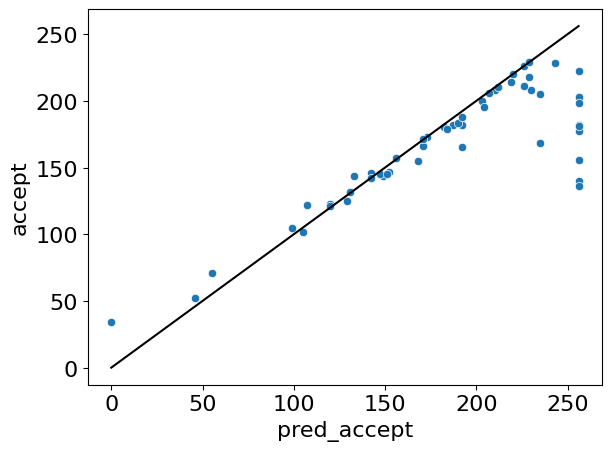

In [21]:
pred_output_NN_df = pd.DataFrame(pred_output_NN)
pred_output_NN_df.columns = ['accuracy', 'pred_accept']

print('median accuracy = ', np.median(pred_output_NN_df.accuracy))
sns.scatterplot(x=pred_output_NN_df.pred_accept, y=pred_output_PT_df.accept, legend=False)
plt.plot([0,256],[0,256], color='black')


We see here that while it does better than the EU model, it does not predict responses as well as the logistic regression or prospect theory models.